In [77]:
import sys
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from torch.optim import Adam

from simdata import  fdd, pdeinp, icinp, bcinp,HT_sim ,scaler, invscaler
from loss_func import loss_fn_data,pde_loss,ic_loss,boundary_loss
from train_testloop import training_loop




## Simulation Data Generation for 1D Heat Transfer

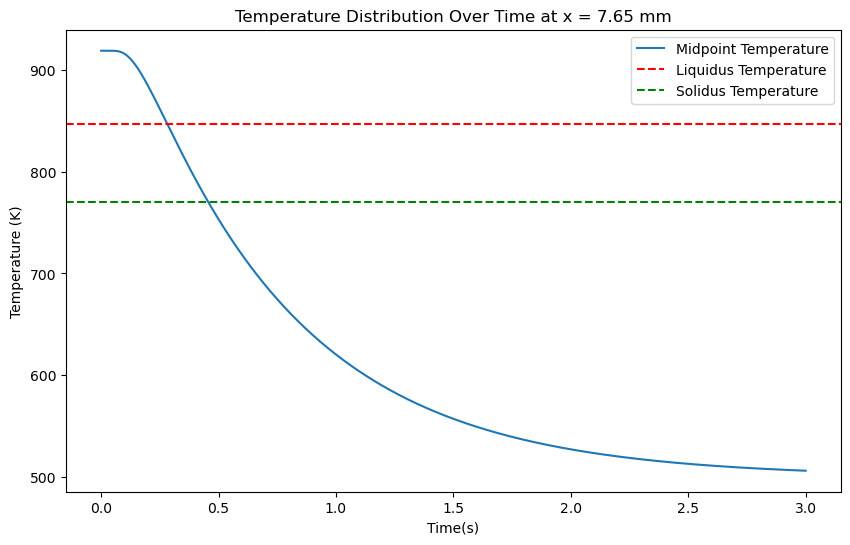

0.0003061224489795918


In [78]:
# The simulation data is generated using the datagen function in simdata.py
# the data solves 1D heat equation with dirichlet boundary conditions

length = 15e-3
time_end = 3.0
numpoints = 50
temp_init = 919.0
t_surr = 500.0

heat_data = HT_sim(length, time_end, numpoints,  t_surr,temp_init)
alpha = heat_data.alpha_l
tempfield = heat_data.datagen()

heat_data.plot_temp(25)

print(heat_data.dx)


## Data Preparation for PINN training

In [79]:

# Temperature dataset
temp_data = tempfield.flatten()

# temp_data = scaler(temp_data,400.0,919.0)

temp_data = temp_data * (1/919.0)

print(temp_data.shape)




(118050,)


### Input Data preparation

In [80]:

# input dataset- fdd
num_steps = tempfield.shape[0]
numpoints = tempfield.shape[1] 



x_c = 1/length
t_c = (alpha/(length**2))
temp_c = 919.0

inp_data = fdd(15e-3, 40, numpoints, num_steps)


def scale2(x,x_c,t_c):
    x[:,0] = x[:,0] * x_c
    x[:,1] = x[:,1] * t_c
    return x

inp_data2 = scale2(inp_data,x_c,t_c)

# input dataset-pde residual

pde_data = pdeinp(0.01,15e-3,0,40,10000,"Hammersley",scl=1)

pde_data2 = scale2(pde_data,x_c,t_c)

# input dataset - ic residual
ic_data = icinp(15e-3,5000,scl="False")
ic_data2 = scale2(ic_data,x_c,t_c)
# input dataset - boundary residual
bc_ldata = bcinp(15e-3,40,5000,scl="False")[0]
bc_rdata = bcinp(15e-3,40,5000,scl="False")[1]

bc_ldata2 = scale2(bc_ldata,x_c,t_c)
bc_rdata2 = scale2(bc_rdata,x_c,t_c)


[0.         0.00030612 0.00061224 ... 0.01438776 0.01469388 0.015     ]


### GPU prep

In [81]:
# check for gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Tensor inputs

In [82]:
input_t = torch.tensor(inp_data2).float().to(device)
inp_pdet = torch.tensor(pde_data2).float().to(device)
inp_ict = torch.tensor(ic_data2).float().to(device)
inp_bclt = torch.tensor(bc_ldata2).float().to(device)
inp_bclr = torch.tensor(bc_rdata2).float().to(device)

print(input_t.shape)

temp_t = torch.tensor(temp_data).float().to(device)
temp_t = temp_t.view(-1,1)
print(temp_t.shape)
temp_init = 919.0/919.0
# temp_init = scaler(temp_init,500.0,919.0)
print(temp_init)
temp_init_t = torch.tensor(temp_init).float().to(device)
T_L = (574.4 +273.0)/919.0                       #  K -Liquidus Temperature (615 c) AL 380
# T_L = scaler(T_L,500.0,919.0)
T_S = (497.3 +273.0)/919.0  
# T_S = scaler(T_S,500.0,919.0)                     #  K -Solidus Temperature (615 c) AL 380
t_surr = 500.0/919.0
# t_surr = scaler(t_surr,500.0,919.0)
T_lt = torch.tensor(T_L).float().to(device)
T_st = torch.tensor(T_S).float().to(device)
t_surrt = torch.tensor(t_surr).float().to(device)

temp_var = {"T_st":T_st,"T_lt":T_lt,"t_surrt":t_surrt,"temp_init_t":temp_init_t}


torch.Size([118050, 2])
torch.Size([118050, 1])
1.0


### Dataset Preparation for pytorch

In [83]:
train_inputs,test_inputs =train_test_split(input_t,test_size=0.2,random_state=42) # input data split
tr_inp_pde,ts_inp_pde = train_test_split( inp_pdet,test_size=0.2,random_state=42) # input pde data split

tr_inp_ic,ts_inp_ic = train_test_split( inp_ict,test_size=0.2,random_state=42) # input ic data split

tr_inp_bcl,ts_inp_bcl = train_test_split( inp_bclt,test_size=0.2,random_state=42) # input bc left data split
tr_inp_bcr,ts_inp_bcr = train_test_split( inp_bclr,test_size=0.2,random_state=42) # input bc right data split

# datasplit output

train_temp,test_temp = train_test_split(temp_t,test_size=0.2,random_state=42) # output data split



In [84]:
class Data_Tensor_Dataset(TensorDataset):#dataset class for tsimulation data
    def __init__(self,inputs,outputs,transform=None, target_transform =None):   
        self.inputs = inputs
        self.outputs = outputs

    def __getitem__(self, index):
        return self.inputs[index],self.outputs[index]
    
    def __len__(self):
        return len(self.inputs)

class ResDataset(TensorDataset): #dataset class for pde residuals and bcs,ics
    def __init__(self, inputs,transform=None, target_transform =None):
        self.inputs = inputs
        

    def __getitem__(self, index):
        return self.inputs[index]
    
    def __len__(self):
        return len(self.inputs)

### Dataset Preparation

In [85]:
inp_dataset = Data_Tensor_Dataset(train_inputs,train_temp)
inp_dataset_test = Data_Tensor_Dataset(test_inputs,test_temp)

inp_pde_dataset = ResDataset(tr_inp_pde)
inp_pde_dataset_test = ResDataset(ts_inp_pde)

inp_ic_dataset = ResDataset(tr_inp_ic)
inp_ic_dataset_test = ResDataset(ts_inp_ic)

inp_bcl_dataset = ResDataset(tr_inp_bcl)
inp_bcl_dataset_test = ResDataset(ts_inp_bcl)

inp_bcr_dataset = ResDataset(tr_inp_bcr)
inp_bcr_dataset_test = ResDataset(ts_inp_bcr)

### Dataloader Preparation

In [86]:
rand_smpl = RandomSampler(inp_dataset, replacement=True, num_samples=10000)
rand_smpl_pde = RandomSampler(inp_pde_dataset, replacement=True, num_samples=len(inp_pde_dataset))
rand_smpl_ic = RandomSampler(inp_ic_dataset, replacement=True, num_samples=len(inp_ic_dataset))
rand_smpl_bcl = RandomSampler(inp_bcl_dataset, replacement=True, num_samples=len(inp_bcl_dataset))
rand_smpl_bcr = RandomSampler(inp_bcr_dataset, replacement=True, num_samples=len(inp_bcr_dataset))

rand_smpl_test = RandomSampler(inp_dataset_test, replacement=True, num_samples=10000)
rand_smpl_pde_test = RandomSampler(inp_pde_dataset_test)
rand_smpl_ic_test = RandomSampler(inp_ic_dataset_test)
rand_smpl_bcl_test = RandomSampler(inp_bcl_dataset_test)
# rand_smpl_bcr_test = RandomSampler(inp_bcr_dataset_test)

train_loader = DataLoader(inp_dataset, batch_size=256, sampler=rand_smpl)
pde_loader = DataLoader(inp_pde_dataset, batch_size=256, sampler=rand_smpl_pde)
ic_loader = DataLoader(inp_ic_dataset, batch_size=256, sampler=rand_smpl_ic)
bcl_loader = DataLoader(inp_bcl_dataset, batch_size=256, sampler=rand_smpl_bcl)
bcr_loader = DataLoader(inp_bcr_dataset, batch_size=256, sampler=rand_smpl_bcr)


test_loader = DataLoader(inp_dataset_test, batch_size=256, shuffle=False)
# pde_loader_test = DataLoader(inp_pde_dataset_test, batch_size=64, sampler=rand_smpl_pde_test)
# ic_loader_test = DataLoader(inp_ic_dataset_test, batch_size=64, sampler=rand_smpl_ic_test)
# bcl_loader_test = DataLoader(inp_bcl_dataset_test, batch_size=64, sampler=rand_smpl_bcl_test)
# bcr_loader_test = DataLoader(inp_bcr_dataset_test, batch_size=64, sampler=rand_smpl_bcr_test)




## NN Architecture Definition

In [87]:
# Define the neural network architecture
class PINN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, hidden_layers):  # Constructor initializes the network
        super(PINN, self).__init__()  # Call the parent class (nn.Module) constructor
        layers = []  # Initialize an empty list to store the network layers

        # Input layer: Takes input features and maps them to the hidden layer size
        layers.append(nn.Linear(input_size, hidden_size))  # Add the first linear layer
        layers.append(nn.Tanh())  # Apply the activation function (Tanh)

        # Hidden layers: Create a series of hidden layers with activation functions
        for _ in range(hidden_layers):  # Loop for creating multiple hidden layers
            layers.append(nn.Linear(hidden_size, hidden_size))  # Add a hidden linear layer
            layers.append(nn.Tanh())  # Add an activation function (Tanh)

        # Output layer: Maps the final hidden layer outputs to the desired output size
        layers.append(nn.Linear(hidden_size, output_size))  # Add the final linear layer
        self.base = nn.Sequential(*layers)  # Create a sequential container with all layers
        
    def forward(self, x, t):  # Define the forward pass of the network
        input_features = torch.cat([x, t], dim=1)  # Concatenate input tensors along dimension 1
        m = self.base(input_features)  # Pass the concatenated input through the network
        return m  # Return the network output


In [88]:
input_size = 2
hidden_size = 5
output_size=1

learning_rate = 0.005
hidden_layers = 5

epochs = 2000

model = PINN(input_size, hidden_size, output_size,hidden_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [89]:
 print(model)

PINN(
  (base): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Tanh()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): Tanh()
    (4): Linear(in_features=5, out_features=5, bias=True)
    (5): Tanh()
    (6): Linear(in_features=5, out_features=5, bias=True)
    (7): Tanh()
    (8): Linear(in_features=5, out_features=5, bias=True)
    (9): Tanh()
    (10): Linear(in_features=5, out_features=5, bias=True)
    (11): Tanh()
    (12): Linear(in_features=5, out_features=1, bias=True)
  )
)


### Loss Function 

In [90]:
torch.autograd.set_detect_anomaly(True)

train_losses, test_losses, pde_losses, bc_losses,ic_losses, data_losses = training_loop(epochs, model, loss_fn_data, optimizer,train_loader,pde_loader,\
                    test_loader,ic_loader,\
                  bcl_loader,bcr_loader,temp_var)  # Train the model
 
# test_losses = test_loop(epochs, model, loss_fn_data, optimizer, train_loader, test_loader)  # Test the model



tensor(1., device='cuda:0')
| Epoch 0,            | Training-Loss 2.9693e+01,| Test-Loss 1.4663e+01   |
--------------------------------------------------------------------------------
| Data-loss 1.7448e-01,| pde-loss 1.0241e-04,        | initc-loss 6.0577e-01,|bc_loss 2.0703e-01|
| Epoch 10,            | Training-Loss 6.9087e-01,| Test-Loss 4.1862e-01   |
--------------------------------------------------------------------------------
| Data-loss 3.3397e-03,| pde-loss 2.0466e-01,        | initc-loss 6.3211e-03,|bc_loss 1.4966e-02|
| Epoch 20,            | Training-Loss 2.9736e-01,| Test-Loss 8.2298e-01   |
--------------------------------------------------------------------------------
| Data-loss 6.3721e-03,| pde-loss 1.9184e-02,        | initc-loss 1.0872e-03,|bc_loss 3.7691e-03|
| Epoch 30,            | Training-Loss 3.0075e-01,| Test-Loss 8.4367e-01   |
--------------------------------------------------------------------------------
| Data-loss 9.0152e-03,| pde-loss 1.3995e-02,  

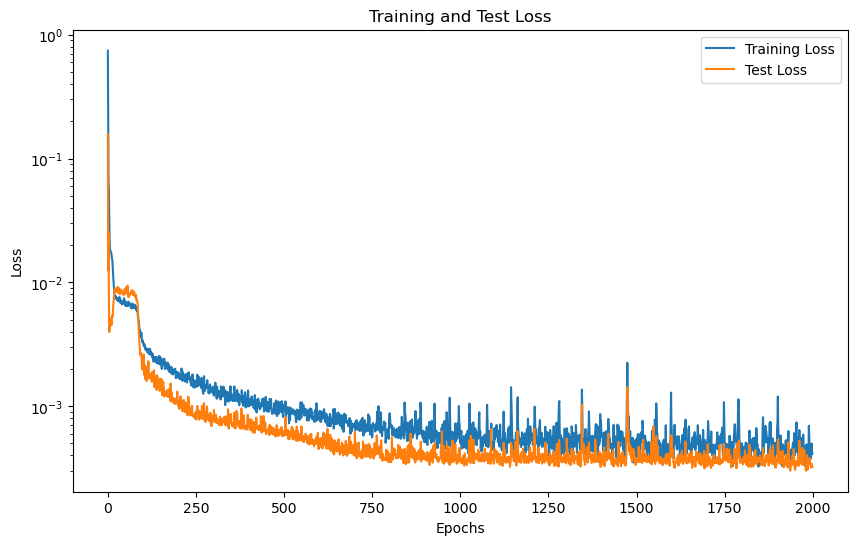

In [91]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

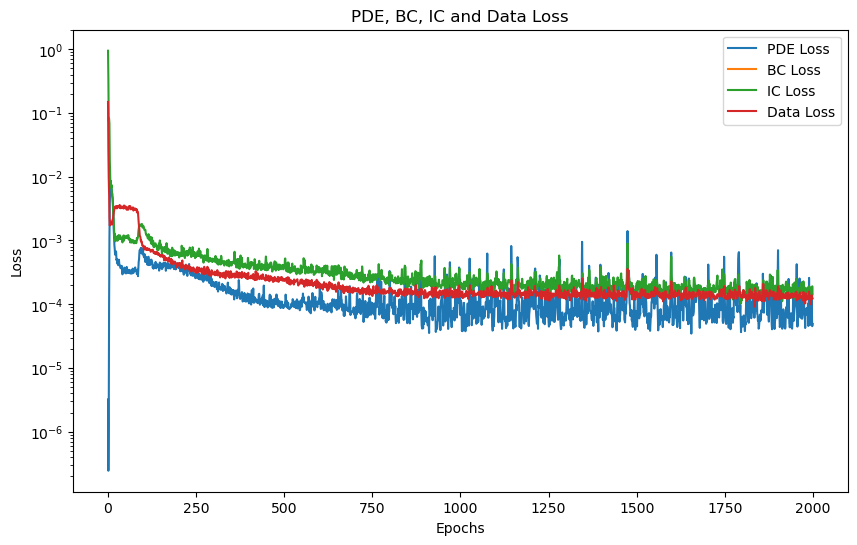

In [92]:
pde_losses = np.array(pde_losses)
bc_losses = np.array(bc_losses)
ic_losses = np.array(ic_losses)

data_losses = np.array(data_losses)

plt.figure(figsize=(10, 6))
plt.plot(pde_losses, label='PDE Loss')
plt.plot(bc_losses, label='BC Loss')
plt.plot(ic_losses, label='IC Loss')
plt.plot(data_losses, label='Data Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('PDE, BC, IC and Data Loss')
plt.legend()
plt.show()



In [2]:

inp_data = torch.tensor(input_t).float().to(device) # Convert the inputs to a tensor
temp_nn = model(inp_data[:,0].unsqueeze(1), inp_data[:,1].unsqueeze(1)).cpu().detach().numpy() # Get the predictions from the model
dx = heat_data.dx
# temp_nn = invscaler(temp_nn,500.0,919.0) # Inverse transform the predictions
temp_nn = temp_nn * 919.0
temp_nn = temp_nn.reshape(num_steps, numpoints) # Reshape the predictions to a 2D array
time_ss= np.linspace(0, 40.0, num_steps )
idx = 25
plt.figure
plt.plot(time_ss, temp_nn[:,idx-1], label='Predicted Temperature')
plt.plot(time_ss, tempfield[:,idx-1], label='Actual Temperature')
plt.xlabel('Time(s)')
plt.ylabel('Temperature (K)')
plt.yscale('linear')
plt.title(f'Predicted vs Actual Temperature at x = {(idx-1)*dx*1000:.2f} mm')
plt.legend()
plt.show()


NameError: name 'torch' is not defined